In [1]:
from glob import glob
import os
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

In [2]:
figpath = '/stanley/WangLab/kamal/figures/projects/manifesto/plaque_metrics_mas/'
os.makedirs(figpath, exist_ok=True)
dpi = 500

# Get minimum distances to plaque centroids

In [3]:
paths = glob('/stanley/WangLab/kamal/data/technologies/starmap/zengetal2023/*disease*replicate_?.h5ad')
samples = [path.split('.')[0].split('/')[-1] for path in paths]

In [4]:
# Calculate independently for each sample

# Save a dictionary of distance metrics per sample
sample2df = dict()

for i in range(len(paths)):

    # Load cell coords
    adata = sc.read_h5ad(paths[i])
    cell_coords = adata.obsm['spatial']

    # Load plaque coords
    df = pd.read_csv(f'/stanley/WangLab/kamal/data/technologies/starmap/mouse_ad/plaque_{samples[i]}.csv')
    plaque_coords = df[['m.cx', 'm.cy']].values

    # Calculate plaque distances
    plaque_dists = np.array([np.linalg.norm(cell_coords-plaque_coords[j], axis=1) for j in range(len(plaque_coords))]).T
    min_plaque_dists = plaque_dists.min(axis=1)

    # Add distance DataFrame to dict
    cell_ids = adata.obs.index.values

    df = pd.DataFrame({'min_plaque_dists':min_plaque_dists}, index=cell_ids)

    sample2df[samples[i]] = df

# Compare region dists to plaque

## Load

In [5]:
paths = glob('/stanley/WangLab/kamal/data/technologies/starmap/mouse_ad/filtered/*juxtacrine_dual.h5ad')
adatas = [sc.read_h5ad(path) for path in paths]

In [6]:
filter_key = 'juxtacrine_dual'
max_mag = 2

for i in range(len(adatas)):

    # Scale
    sc.pp.scale(adatas[i], layer=filter_key)

    # Clip
    X = adatas[i].layers[filter_key]
    X[X > max_mag] = max_mag
    X[X < -max_mag] = -max_mag

adata = sc.concat(adatas)

## Embed

In [7]:
def embed(adata, samples1, samples2, n_comps, filter_key):

    adata1 = adata[np.isin(adata.obs['sample'],samples1)]
    adata2 = adata[np.isin(adata.obs['sample'],samples2)]

    X = adata1.layers[filter_key]
    X -= X.mean(axis=0)
    A = X.T @ X

    X_ = adata2.layers[filter_key]
    X_ -= X_.mean(axis=0)
    B = X_.T @ X_

    w,V = eigh(A,B)
    w = w[::-1]
    V = V[:,::-1]

    V = V[:,:n_comps]
    adata.obsm[f'X_pca_{filter_key}'] = adata.layers[filter_key] @ V
    adata.varm[f'X_pca_{filter_key}'] = V
    adata.uns[f'comp_var_{filter_key}'] = w

    return V

In [8]:
samples = adata.obs['sample'].unique()
samples1 = [sample for sample in samples if 'disease' in sample]
samples2 = [sample for sample in samples if 'control' in sample]

In [9]:
n_comps = 1
V = embed(adata, samples1, samples2, n_comps, filter_key)

In [10]:
subdata = adata[adata.obs['condition']=='disease'].copy()
subdata.obs['pc1_region'] = subdata.layers[filter_key] @ V[:,0]

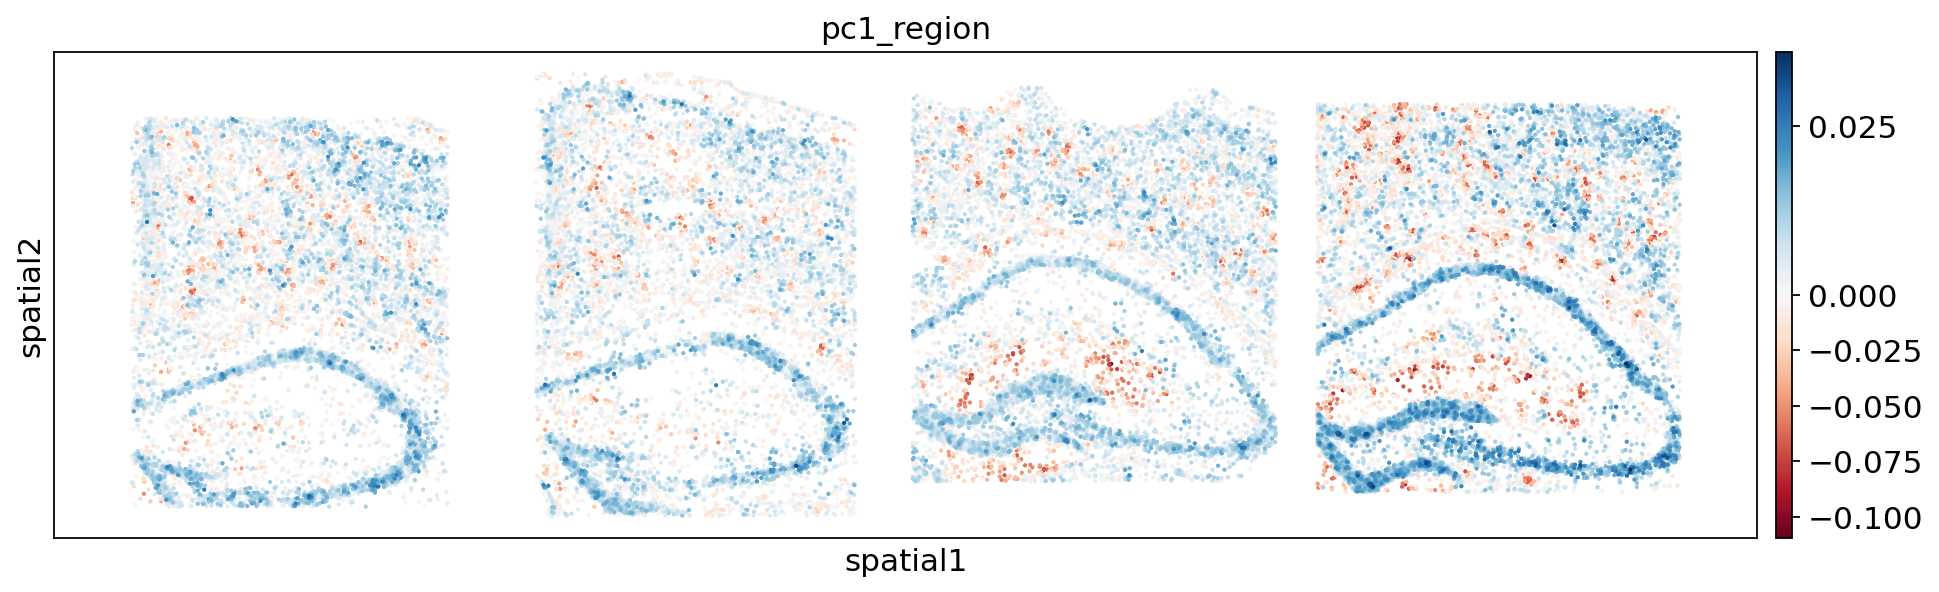

In [11]:
sc.set_figure_params(figsize=(15,4))
sc.pl.embedding(
    subdata,
    basis='spatial',
    color='pc1_region',
    cmap='RdBu',
    vcenter=0,
    s=15,
)

In [12]:
subdatas = [subdata[subdata.obs['sample']==sample] for sample in subdata.obs['sample'].unique()]

for subdata in subdatas:
    sample = subdata.obs['sample'].iloc[0]
    dists = sample2df[sample]
    subdata.obs['min_plaque_dist'] = dists.loc[subdata.obs.index].values.flatten()

/local/scratch/44898265.1.interactive/ipykernel_181520/3197103647.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  subdata.obs['min_plaque_dist'] = dists.loc[subdata.obs.index].values.flatten()
/local/scratch/44898265.1.interactive/ipykernel_181520/3197103647.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  subdata.obs['min_plaque_dist'] = dists.loc[subdata.obs.index].values.flatten()
/local/scratch/44898265.1.interactive/ipykernel_181520/3197103647.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  subdata.obs['min_plaque_dist'] = dists.loc[subdata.obs.index].values.flatten()
/local/scratch/44898265.1.interactive/ipykernel_181520/3197103647.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  subdata.obs['min_plaque_dist'] = dists.loc[subdata.obs.index].v

In [13]:
adata = sc.concat(subdatas)

## Compare

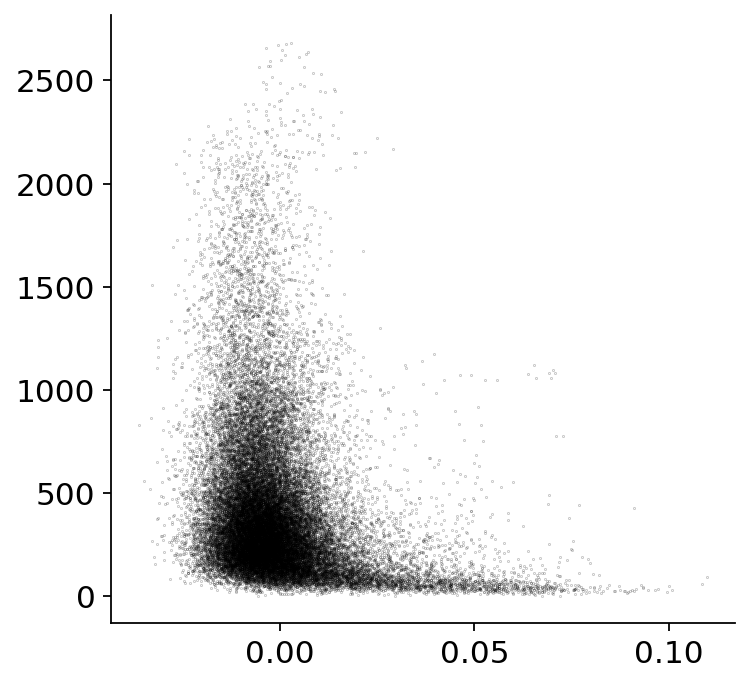

In [14]:
x_region,y_region = adata.obs[['pc1_region', 'min_plaque_dist']].values.T

plt.figure(figsize=(5,5))
plt.scatter(-x_region,y_region, s=0.03, marker='.', c='k') # negate x so that positive = plaque
# plt.xlabel('PC1')
# plt.ylabel('Min. Dist. to Plaque Centroid')
plt.grid(False)
plt.gca().spines[['top','right']].set_visible(False)
filename = os.path.join(figpath, f'region_vs_dist.png')
plt.savefig(filename, dpi=dpi)
plt.show()

# Compare interaction dists to plaque

## Load

In [15]:
paths = glob('/stanley/WangLab/kamal/data/technologies/starmap/mouse_ad/filtered/*juxtacrine.h5ad')
adatas = [sc.read_h5ad(path) for path in paths]

In [16]:
filter_key = 'juxtacrine'
max_mag = 2

for i in range(len(adatas)):

    # Scale
    sc.pp.scale(adatas[i], layer=filter_key)

    # Clip
    X = adatas[i].layers[filter_key]
    X[X > max_mag] = max_mag
    X[X < -max_mag] = -max_mag

adata = sc.concat(adatas)

## Embed

In [17]:
def embed(adata, samples1, samples2, n_comps, filter_key):

    adata1 = adata[np.isin(adata.obs['sample'],samples1)]
    adata2 = adata[np.isin(adata.obs['sample'],samples2)]

    X = adata1.layers[filter_key]
    X -= X.mean(axis=0)
    A = X.T @ X

    X_ = adata2.layers[filter_key]
    X_ -= X_.mean(axis=0)
    B = X_.T @ X_

    w,V = eigh(A,B)
    w = w[::-1]
    V = V[:,::-1]

    V = V[:,:n_comps]
    adata.obsm[f'X_pca_{filter_key}'] = adata.layers[filter_key] @ V
    adata.varm[f'X_pca_{filter_key}'] = V
    adata.uns[f'comp_var_{filter_key}'] = w

    return V

In [18]:
samples = adata.obs['sample'].unique()
samples1 = [sample for sample in samples if 'disease' in sample]
samples2 = [sample for sample in samples if 'control' in sample]

In [19]:
n_comps = 1
V = embed(adata, samples1, samples2, n_comps, filter_key)

In [20]:
subdata = adata[adata.obs['condition']=='disease'].copy()
subdata.obs['pc1_ixn'] = subdata.layers[filter_key] @ V[:,0]

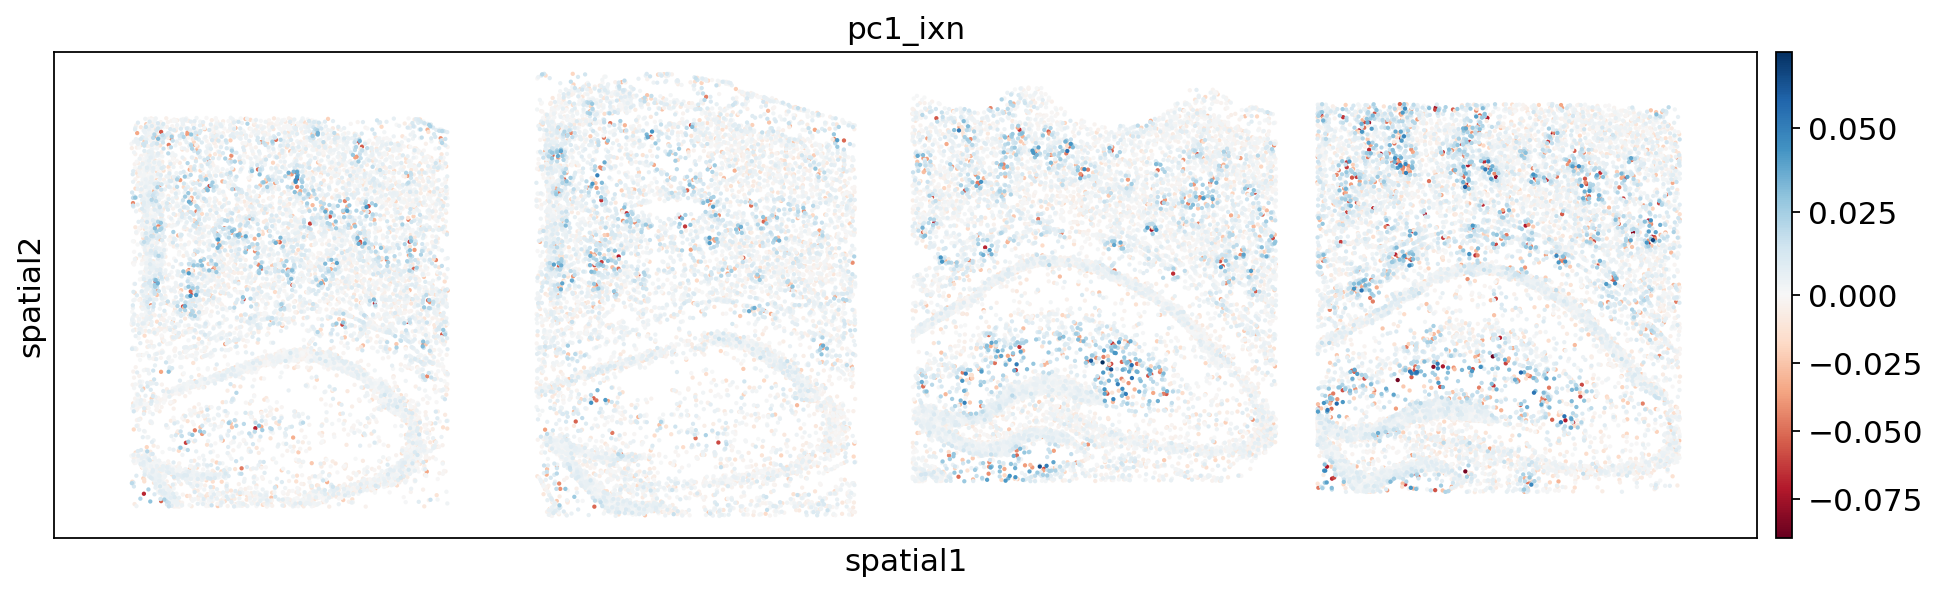

In [21]:
sc.set_figure_params(figsize=(15,4))
sc.pl.embedding(
    subdata,
    basis='spatial',
    color='pc1_ixn',
    cmap='RdBu',
    vcenter=0,
    s=15,
)

In [22]:
subdatas = [subdata[subdata.obs['sample']==sample] for sample in subdata.obs['sample'].unique()]

for subdata in subdatas:
    sample = subdata.obs['sample'].iloc[0]
    dists = sample2df[sample]
    subdata.obs['min_plaque_dist'] = dists.loc[subdata.obs.index].values.flatten()

/local/scratch/44898265.1.interactive/ipykernel_181520/3197103647.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  subdata.obs['min_plaque_dist'] = dists.loc[subdata.obs.index].values.flatten()
/local/scratch/44898265.1.interactive/ipykernel_181520/3197103647.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  subdata.obs['min_plaque_dist'] = dists.loc[subdata.obs.index].values.flatten()
/local/scratch/44898265.1.interactive/ipykernel_181520/3197103647.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  subdata.obs['min_plaque_dist'] = dists.loc[subdata.obs.index].values.flatten()
/local/scratch/44898265.1.interactive/ipykernel_181520/3197103647.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  subdata.obs['min_plaque_dist'] = dists.loc[subdata.obs.index].v

In [23]:
adata = sc.concat(subdatas)

## Compare

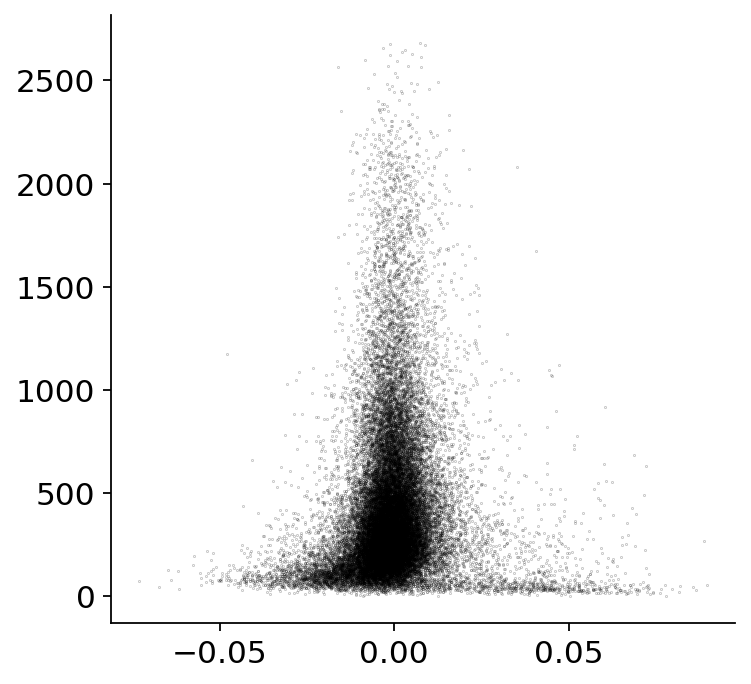

In [24]:
x_ixn,y_ixn = adata.obs[['pc1_ixn', 'min_plaque_dist']].values.T

plt.figure(figsize=(5,5))
plt.scatter(-x_ixn,y_ixn, s=0.03, marker='.', c='k') # negate x so that positive = plaque
# plt.xlabel('PC1')
# plt.ylabel('Min. Dist. to Plaque Centroid')
plt.grid(False)
plt.gca().spines[['top','right']].set_visible(False)
filename = os.path.join(figpath, f'ixn_vs_dist.png')
plt.savefig(filename, dpi=dpi)
plt.show()